# UFC Fighter Age vs Win Rate Analysis using Lagrange Interpolation
This notebook analyzes UFC fighter performance based on age using numerical computation methods. Specifically, it uses **Lagrange interpolation** to estimate win rate at a given age.

In [1]:
# Step 1: Load and merge the cleaned datasets
import pandas as pd
import numpy as np

# Load datasets
df_stats = pd.read_csv('../Data Cleaning/cleaned data/cleaned_ufc_fight_stat_data.csv')
df_fights = pd.read_csv('../Data Cleaning/cleaned data/cleaned_ufc_fight_data.csv')
df_fighters = pd.read_csv('../Data Cleaning/cleaned data/cleaned_ufc_fighter_data.csv')

# Merge stats with fighter attributes
df = pd.merge(df_stats, df_fighters, on="fighter_id", how="left")
# Merge with fight results
df = pd.merge(df, df_fights[["fight_id", "f_1", "f_2", "winner"]], on="fight_id", how="left")

def determine_win(row):
    if row['fighter_id'] == row['f_1']:
        return 1 if row['winner'] == row['f_1'] else 0
    elif row['fighter_id'] == row['f_2']:
        return 1 if row['winner'] == row['f_2'] else 0
    else:
        return np.nan
df['win_flag'] = df.apply(determine_win, axis=1)

# Calculate age assuming fights happened in 2023
df['fighter_dob'] = pd.to_datetime(df['fighter_dob'], errors='coerce')
df['fighter_age'] = 2023 - df['fighter_dob'].dt.year
df = df.dropna(subset=['fighter_age', 'win_flag'])

In [2]:
# Step 2: Compute average win rate by age
age_winrate_df = (
    df.groupby("fighter_age")["win_flag"]
    .mean()
    .reset_index()
    .sort_values("fighter_age")
)
sampled = age_winrate_df.iloc[::2].copy()
x_vals = sampled["fighter_age"].values
y_vals = sampled["win_flag"].values

In [3]:
# Step 3: Define Lagrange interpolation function
def lagrange_interpolation(x_points, y_points, x):
    total = 0
    n = len(x_points)
    for i in range(n):
        xi, yi = x_points[i], y_points[i]
        li = 1
        for j in range(n):
            if i != j:
                li *= (x - x_points[j]) / (xi - x_points[j])
        total += yi * li
    return total

# Interpolate win rate at age 28.5
interp_age = 28.5
interp_winrate = lagrange_interpolation(x_vals, y_vals, interp_age)
print(f"Interpolated win rate at age {interp_age}: {interp_winrate:.3f}")

Interpolated win rate at age 28.5: 0.442


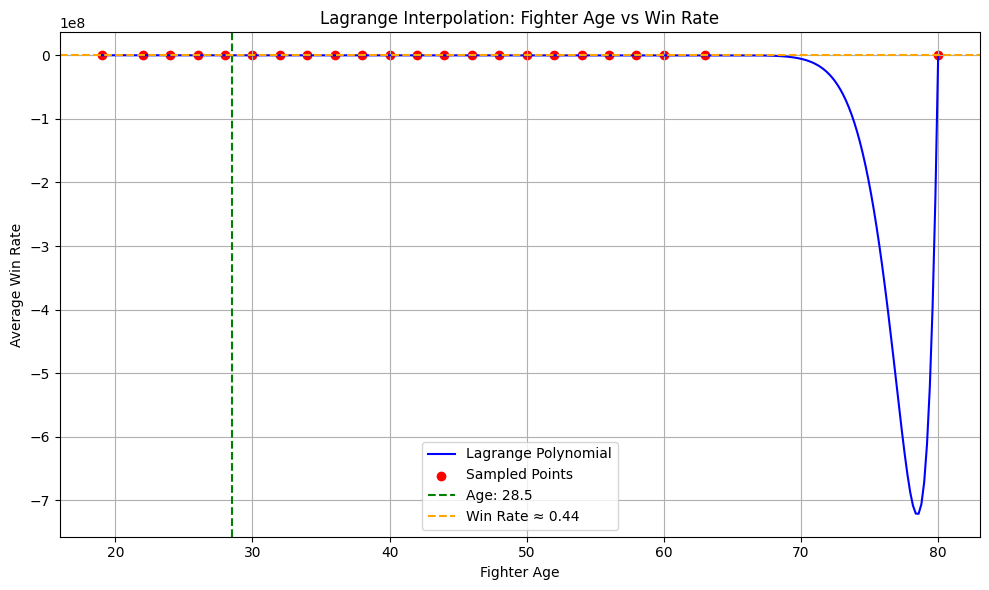

In [4]:
# Step 4: Plot the results
import matplotlib.pyplot as plt

x_plot = np.linspace(min(x_vals), max(x_vals), 300)
y_plot = [lagrange_interpolation(x_vals, y_vals, x) for x in x_plot]

plt.figure(figsize=(10, 6))
plt.plot(x_plot, y_plot, label="Lagrange Polynomial", color="blue")
plt.scatter(x_vals, y_vals, color="red", label="Sampled Points")
plt.axvline(x=interp_age, color="green", linestyle="--", label=f"Age: {interp_age}")
plt.axhline(y=interp_winrate, color="orange", linestyle="--", label=f"Win Rate ≈ {interp_winrate:.2f}")
plt.title("Lagrange Interpolation: Fighter Age vs Win Rate")
plt.xlabel("Fighter Age")
plt.ylabel("Average Win Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()